# Plan-and-Execute

이 튜토리얼에서는 "plan-and-execute" 스타일의 에이전트를 만드는 방법을 소개하고, 이를 [LangGraph](https://langchain-ai.github.io/langgraph/)를 활용하여 구현하는 과정을 단계별로 설명합니다.  
"plan-and-execute" 전략은 복잡한 작업을 수행할 때 장기적인 계획을 먼저 수립한 뒤, 해당 계획을 단계별로 실행하며 필요에 따라 다시 계획을 재수정하는 접근법입니다.

![](./assets/langgraph-plan-and-execute.png)

---

## Plan-and-Execute란 무엇인가?

"plan-and-execute"는 다음과 같은 특징을 갖는 접근 방식입니다.

- **장기 계획 수립**: 복잡한 작업을 수행하기 전에 큰 그림을 그리는 장기 계획을 수립합니다.
- **단계별 실행 및 재계획**: 세운 계획을 단계별로 실행하고, 각 단계가 완료될 때마다 계획이 여전히 유효한지 검토한 뒤 수정할 수 있습니다.
  
이 방식은 [Plan-and-Solve 논문](https://arxiv.org/abs/2305.04091)과 [Baby-AGI 프로젝트](https://github.com/yoheinakajima/babyagi)에서 영감을 받았습니다. 전통적인 [ReAct 스타일](https://arxiv.org/abs/2210.03629)의 에이전트는 한 번에 한 단계씩 생각하는 반면, "plan-and-execute"는 명시적이고 장기적인 계획을 강조합니다.

**장점**:
1. **명시적인 장기 계획**: 강력한 LLM조차도 한 번에 장기 계획을 처리하는 데 어려움을 겪을 수 있습니다. 명시적으로 장기 계획을 수립함으로써, 보다 안정적인 진행이 가능합니다.
2. **효율적인 모델 사용**: 계획 단계에서는 더 큰/강력한 모델을 사용하고, 실행 단계에서는 상대적으로 작은/약한 모델을 사용함으로써 자원 소비를 최적화할 수 있습니다.

---

**주요 내용**

- **도구 정의**: 사용할 도구 정의
- **실행 에이전트 정의**: 실제 작업을 실행하는 에이전트 생성
- **상태 정의**: 에이전트의 상태 정의
- **계획 단계**: 장기 계획을 세우는 단계 생성
- **재계획 단계**: 작업 진행 상황에 따라 계획을 재수정하는 단계 생성
- **그래프 생성 및 실행**: 이러한 단계들을 연결하는 그래프 생성 및 실행

---

**참고**

- [LangGraph 공식 문서](https://langchain-ai.github.io/langgraph/)  
- [Plan-and-Solve 논문](https://arxiv.org/abs/2305.04091)  
- [Baby-AGI 프로젝트](https://github.com/yoheinakajima/babyagi)  
- [ReAct 논문](https://arxiv.org/abs/2210.03629)

지금부터는 각 단계를 따라가며 "plan-and-execute" 에이전트를 LangGraph로 구현하는 방법을 자세히 알아보겠습니다.

## 환경 설정

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# # LangSmith 추적을 설정합니다. https://smith.langchain.com
# # !pip install -qU langchain-teddynote
# from langchain_teddynote import logging

# # 프로젝트 이름을 입력합니다.
# logging.langsmith("CH17-LangGraph-Use-Cases")

<br>

## 🧪 Step 1. Test and Construct each module
---

### Web Search Tool

Web search tool is used to enhance the context. <br>

It is used when all the documents do not meet the relevance threshold or the evaluator is not confident.

In [3]:
from azure_genai_utils.tools import BingSearch

WEB_SEARCH_FORMAT_OUTPUT = False

web_search_tool = BingSearch(
    max_results=5,
    locale="en-US",
    include_news=True,
    include_entity=False,
    format_output=WEB_SEARCH_FORMAT_OUTPUT,
)

tools = [web_search_tool]

### Define your LLM

This hands-on only uses the `gpt-4o-mini`, but you can utilize multiple models in the pipeline.

In [ ]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(model="gpt-4o-mini", temperature=0)

### Define ReAct Agent

Define the ReAct agent that will be used to execute the plan.<br>
LangGraph provides a simple ReAct agent that can be used to execute the plan.

In [4]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. Answer in Korean.",
        ),
        ("human", "{messages}"),
    ]
)

# Create ReAct agent
agent_executor = create_react_agent(llm, tools, state_modifier=prompt)

In [5]:
agent_executor.invoke(
    {"messages": [("user", "랭체인 한국어 튜토리얼에 대해서 설명해줘")]}
)

{'messages': [HumanMessage(content='랭체인 한국어 튜토리얼에 대해서 설명해줘', additional_kwargs={}, response_metadata={}, id='74dd3c75-0987-4ac9-897c-c8525ae08dfc'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_56WfV6pKo8mF7M0aLUd8RFyw', 'function': {'arguments': '{"query":"랭체인 한국어 튜토리얼"}', 'name': 'bing_search_results'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 143, 'total_tokens': 170, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9018c82e-4fea-4c88-9f13-6a45cfe95896-0', tool_calls=[{'name': 'bing_search_results', 'args': {'query': '랭체인 한국어 튜토리얼'}, 'id': 'call_56WfV6pKo8mF7M0aLUd8RFyw', 'type': 'tool_call'}],

## 상태 정의

- `input`: 사용자의 입력
- `plan`: 현재 계획
- `past_steps`: 이전에 실행한 계획과 실행 결과
- `response`: 최종 응답

In [6]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


class PlanExecute(TypedDict):
    input: Annotated[str, "User's input"]
    plan: Annotated[List[str], "Current plan"]
    past_steps: Annotated[List[Tuple], operator.add]
    response: Annotated[str, "Final response"]

## 계획(Plan) 단계

이제 **계획 단계**를 생성하는 방법을 고려해 보겠습니다. 이 단계에서는 `function calling` 을 사용하여 계획을 수립합니다.

In [7]:
from pydantic import BaseModel, Field
from typing import List


# Plan 모델 정의
class Plan(BaseModel):
    """Sorted steps to execute the plan"""

    steps: Annotated[List[str], "Different steps to follow, should be in sorted order"]

In [8]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# 계획 수립을 위한 프롬프트 템플릿 생성
planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.
Answer in Korean.""",
        ),
        ("placeholder", "{messages}"),
    ]
)

planner = planner_prompt | ChatOpenAI(
    model="gpt-4o-mini", temperature=0
).with_structured_output(Plan)

`planner` 를 실행하여 계획을 수립한 결과를 확인합니다.

In [9]:
# Planner 실행
planner.invoke(
    {
        "messages": [
            (
                "user",
                "LangGraph 의 핵심 장단점과 LangGraph 를 사용하는 이유는 무엇인가?",
            )
        ]
    }
)

Failed to use model_dump to serialize <class 'pydantic._internal._model_construction.ModelMetaclass'> to JSON: TypeError("BaseModel.model_dump() missing 1 required positional argument: 'self'")
Failed to use dict to serialize <class 'pydantic._internal._model_construction.ModelMetaclass'> to JSON: TypeError("BaseModel.dict() missing 1 required positional argument: 'self'")
Failed to use model_dump to serialize <class 'pydantic._internal._model_construction.ModelMetaclass'> to JSON: TypeError("BaseModel.model_dump() missing 1 required positional argument: 'self'")
Failed to use dict to serialize <class 'pydantic._internal._model_construction.ModelMetaclass'> to JSON: TypeError("BaseModel.dict() missing 1 required positional argument: 'self'")
Failed to use model_dump to serialize <class 'pydantic._internal._model_construction.ModelMetaclass'> to JSON: TypeError("BaseModel.model_dump() missing 1 required positional argument: 'self'")
Failed to use dict to serialize <class 'pydantic._inte

Plan(steps=['LangGraph의 정의와 기능을 이해한다.', 'LangGraph의 핵심 장점을 정리한다.', 'LangGraph의 핵심 단점을 정리한다.', 'LangGraph를 사용하는 이유를 분석한다.', '각 장단점과 사용 이유를 종합하여 최종 결론을 도출한다.'])

## 재계획(Re-Plan) 단계

이제 이전 단계의 결과를 바탕으로 계획을 다시 수립하는 단계를 생성합니다.

In [10]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    # 사용자 응답
    response: str


class Act(BaseModel):
    """Action to perform."""

    # 수행할 작업: "Response", "Plan". 사용자에게 응답할 경우 Response 사용, 추가 도구 사용이 필요할 경우 Plan 사용
    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


# 계획을 재수립하기 위한 프롬프트 정의
replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan.

Answer in Korean."""
)


# Replanner 생성
replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o-mini", temperature=0
).with_structured_output(Act)

## 그래프 생성

이제 그래프를 생성할 수 있습니다.

In [11]:
llm

ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x157104950>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x156eb0800>, root_client=<openai.OpenAI object at 0x156eb09b0>, root_async_client=<openai.AsyncOpenAI object at 0x1571049b0>, model_name='gpt-4o-mini', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'))

In [12]:
from langchain_core.output_parsers import StrOutputParser


# 사용자 입력을 기반으로 계획을 생성하고 반환
def plan_step(state: PlanExecute):
    plan = planner.invoke({"messages": [("user", state["input"])]})
    # 생성된 계획의 단계 리스트 반환
    return {"plan": plan.steps}


# 에이전트 실행기를 사용하여 주어진 작업을 수행하고 결과를 반환
def execute_step(state: PlanExecute):
    plan = state["plan"]
    # 계획을 문자열로 변환하여 각 단계에 번호를 매김
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    # 현재 실행할 작업을 포맷팅하여 에이전트에 전달
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing [step 1. {task}]."""
    # 에이전트 실행기를 통해 작업 수행 및 결과 수신
    agent_response = agent_executor.invoke({"messages": [("user", task_formatted)]})
    # 이전 단계와 그 결과를 포함하는 딕셔너리 반환
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


# 이전 단계의 결과를 바탕으로 계획을 업데이트하거나 최종 응답을 반환
def replan_step(state: PlanExecute):
    output = replanner.invoke(state)
    # 응답이 사용자에게 반환될 경우
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    # 추가 단계가 필요할 경우 계획의 단계 리스트 반환
    else:
        next_plan = output.action.steps
        if len(next_plan) == 0:
            return {"response": "No more steps needed."}
        else:
            return {"plan": next_plan}


# 에이전트의 실행 종료 여부를 결정하는 함수
def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return "final_report"
    else:
        return "execute"


final_report_prompt = ChatPromptTemplate.from_template(
    """You are given the objective and the previously done steps. Your task is to generate a final report in markdown format.
Final report should be written in professional tone.

Your objective was this:

{input}

Your previously done steps(question and answer pairs):

{past_steps}

Generate a final report in markdown format. Write your response in Korean."""
)

final_report = final_report_prompt | llm | StrOutputParser()


def generate_final_report(state: PlanExecute):
    past_steps = "\n\n".join(
        [
            f"Question: {past_step[0]}\n\nAnswer: {past_step[1]}\n\n####"
            for past_step in state["past_steps"]
        ]
    )
    response = final_report.invoke({"input": state["input"], "past_steps": past_steps})
    return {"response": response}

## 그래프 생성

이제 지금까지 정의한 노드를 연결하여 그래프를 생성합니다.

In [13]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver


# 그래프 생성
workflow = StateGraph(PlanExecute)

# 노드 정의
workflow.add_node("planner", plan_step)
workflow.add_node("execute", execute_step)
workflow.add_node("replan", replan_step)
workflow.add_node("final_report", generate_final_report)

# 엣지 정의
workflow.add_edge(START, "planner")
workflow.add_edge("planner", "execute")
workflow.add_edge("execute", "replan")
workflow.add_edge("final_report", END)

# 조건부 엣지: replan 후 종료 여부를 결정하는 함수 사용
workflow.add_conditional_edges(
    "replan",
    should_end,
    {"execute": "execute", "final_report": "final_report"},
)

# 그래프 컴파일
app = workflow.compile(checkpointer=MemorySaver())

그래프를 시각화 합니다.

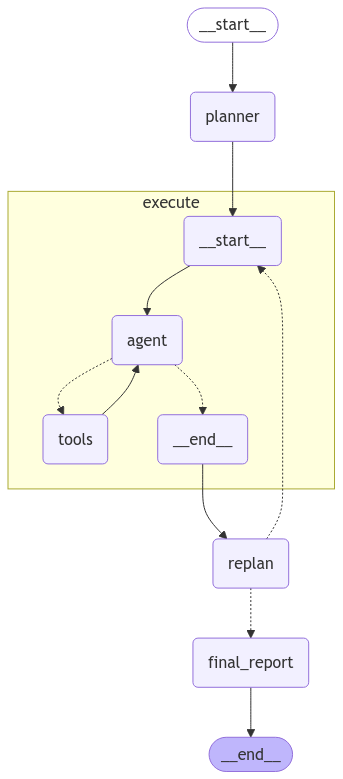

In [14]:
from azure_genai_utils.langgraph.utils import visualize_graph

visualize_graph(app, xray=True)

## 그래프 실행

In [16]:
from azure_genai_utils.messages import stream_graph, invoke_graph, random_uuid
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=40, configurable={"thread_id": random_uuid()})

inputs = {"input": "AutoGen에 대해 설명해주고 LangGraph와 다른 점도 설명해줘"}

invoke_graph(app, inputs, config)


🔄 Node: planner 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
AutoGen의 정의를 설명한다.
AutoGen의 주요 기능과 특징을 나열한다.
LangGraph의 정의를 설명한다.
LangGraph의 주요 기능과 특징을 나열한다.
AutoGen과 LangGraph의 차이점을 비교한다.

🔄 Node: agent in [execute] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

AutoGen은 자동으로 코드를 생성하는 시스템 또는 도구를 의미합니다. 일반적으로 인공지능(AI) 기술을 활용하여 사용자의 요구사항에 맞는 코드를 작성하거나, 특정 작업을 수행하기 위한 프로그램을 자동으로 생성하는 기능을 가지고 있습니다. AutoGen은 개발자의 생산성을 높이고, 반복적인 작업을 줄이며, 코드의 일관성을 유지하는 데 도움을 줍니다. 이러한 시스템은 자연어 처리(NLP) 기술을 통해 사용자의 의도를 이해하고, 그에 맞는 코드를 생성하는 데 중점을 둡니다.

🔄 Node: execute 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
('AutoGen의 정의를 설명한다.', 'AutoGen은 자동으로 코드를 생성하는 시스템 또는 도구를 의미합니다. 일반적으로 인공지능(AI) 기술을 활용하여 사용자의 요구사항에 맞는 코드를 작성하거나, 특정 작업을 수행하기 위한 프로그램을 자동으로 생성하는 기능을 가지고 있습니다. AutoGen은 개발자의 생산성을 높이고, 반복적인 작업을 줄이며, 코드의 일관성을 유지하는 데 도움을 줍니다. 이러한 시스템은 자연어 처리(NLP) 기술을 통해 사용자의 의도를 이해하고, 그에 맞는 코드를 생성하는 데 중점을 둡니다.')

🔄 Node: rep

GraphRecursionError: Recursion limit of 40 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [ ]:
snapshot = app.get_state(config).values
print(snapshot["response"])

In [ ]:
from IPython.display import Markdown

Markdown(snapshot["response"])

In [ ]:
print(snapshot["response"])